# Introduction

La pratique de l'aviron en milieu naturel, comme sur les fleuves et rivières, dépend fortement des conditions hydrologiques telles que le débit, la température extérieure ou la hauteur d'eau. Ces paramètres jouent un rôle crucial dans la sécurité des rameurs, la qualité de l'expérience sportive, et l'organisation des entraînements et des compétitions. 
La Fédération Française d'Aviron a donc émis des lignes directrices de sécurité, dont les principes sont généralement appliqués au sein des clubs français : les sorties sur les plans d'eaux sont interdites lorsque le débit est trop puissant. Les variations du débit, souvent influencées par les conditions météorologiques (pluies, sécheresses), rendent leur prévision essentielle pour les clubs d'aviron et leurs pratiquants. Ce projet, centré sur la Seine, vise donc à développer un modèle de prédiction des conditions de bassin : il permettra d'anticiper les jours où les conditions sont optimales pour la pratique de l'aviron et à l'inverse les jours où les sorties seront trop dangereuses, en se fondant sur des données hydrométriques et météorologiques. Ce travail combine une analyse des données historiques et actuelles, et fournira la base d'un outil fiable et pratique pour faciliter la planification dans les clubs d'aviron en facilitant le respect des normes de sécurité de la pratique sportive.

Ce projet comprend 3 grandes parties : 
- Dans la première partie, nous importons les bases de données utiles
- Dans la deuxième partie, nous étudions et analysons les données recueillies pour préparer le modèle prédictif
- Dans la troisième partie, nous modélisons le problème pour tenter d'y apporter une réponse satisfaisante. Pour des questions de commodité et de rapidité d'exécution, nous avons choisi d'entraîner le modèle sur les données d'un peu plus d'un an (1er janvier 2023-30 novembre 2024).

# Conclusion

# Mise en perspective
Le modèle pourrait être étendu et utilisé par tous les clubs d'aviron, à condition d'une mise à disposition plus aisée de la base des données de débit aux stations hydrométriques. En effet,  data.gouv propose deux manières d'accéder aux données hydrométriques : 
1. une API accessible par URL, permettant d'avoir accès à toutes les données de débit en France mais uniquement sur les 30 derniers jours
2. des archives des données hydrométriques, accessibles uniquement par téléchargement manuel pour chaque station hydrométrique d'intérêt. 

Afin de ne pas perdre de temps à télécharger des centaines de bases de données hydrométriques nous avons donc choisi de restreindre notre modèle à la Seine. 

In [3]:
# !pip install cartopy
# !pip install geopy

In [2]:
import os
import requests
from IPython.display import Markdown, display
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import glob

from datetime import datetime, timedelta
from scipy.spatial import distance

In [3]:
os.chdir("/home/onyxia/work/Projet-de-Python-Leroux-Gisserot") # pour l'emplacement
os.environ["PROJ_LIB"] = "/opt/conda/share/proj" # pour les projections sur carte

# 1. Data loading

Dans cette partie, nous importons :
- des bases de données météo horaire, classées par département (data.gouv.fr)
- des bases de données concernant les archives du débit de la Seine, pour chaque station hydrométrique d'intérêt
- une base de données permettant de tracer les cours d'eau sur une carte
- une base de données permettant de localiser les clubs d'aviron
- une base de données regroupant les informations des clubs d'aviron et des stations météorologique et hydrométriques les plus proches

In [13]:
from utils.data_loading import (
    read_csv_from_url, 
    load_department_data,
    load_and_save_all_department_data,
    load_data_from_disk,
    cleaning_and_organizing,
    get_coordinates,
    import_geojson_from_url,
    find_nearest_station,
    add_station_info_to_clubs,
)

---

### Bases de données météo horaire
Téléchargement (data.gouv.fr), concaténation et nettoyage. Nous nous sommes concentrés sur les départements dans lesquels passe la Seine afin d'obtenir les données météo des localisations proches des clubs d'aviron de long de la Seine.

In [14]:
'''load_and_save_all_department_data(
    department_ids=["10", "27", "76", "77", "78", "91", "92", "95"], # départements par lesquels passe la Seine
    save_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24"
)'''

'load_and_save_all_department_data(\n    department_ids=["10", "27", "76", "77", "78", "91", "92", "95"], # départements par lesquels passe la Seine\n    save_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24"\n)'

In [15]:
meteo_horaire = load_data_from_disk(data_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24")

Loading and concatenating data from disk: 100%|██████████| 8/8 [00:00<00:00, 10.22it/s]


In [16]:
meteo_horaire = cleaning_and_organizing(
                                df=meteo_horaire,
                                columns=["DEPARTMENT_ID", "NOM_USUEL", "AAAAMMJJHH"],
                                date="AAAAMMJJHH"
                            )
                            
meteo_horaire                    

,DEPARTMENT_ID,NUM_POSTE,NOM_USUEL,LAT,LON,AAAAMMJJHH,RR1,T
0,10,10002001,AILLEVILLE_SAPC,48.254167,4.685667,2023-01-01 00:00:00,0.0,14.2
1,10,10002001,AILLEVILLE_SAPC,48.254167,4.685667,2023-01-01 01:00:00,0.0,14.3
2,10,10002001,AILLEVILLE_SAPC,48.254167,4.685667,2023-01-01 02:00:00,0.0,14.2
3,10,10002001,AILLEVILLE_SAPC,48.254167,4.685667,2023-01-01 03:00:00,0.0,14.3
4,10,10002001,AILLEVILLE_SAPC,48.254167,4.685667,2023-01-01 04:00:00,0.0,14.0
...,...,...,...,...,...,...,...,...
104851,95,95690001,WY-DIT,49.108167,1.830667,2024-12-28 23:00:00,0.0,0.8
104852,95,95690001,WY-DIT,49.108167,1.830667,2024-12-29 00:00:00,0.0,1.0
104853,95,95690001,WY-DIT,49.108167,1.830667,2024-12-29 01:00:00,0.0,1.1
104854,95,95690001,WY-DIT,49.108167,1.830667,2024-12-29 02:00:00,0.0,1.1


Le dataframe meteo_horaire contient les colonnes suivantes :
- DEPARTMENT_ID : le numéro du département où se trouve la station météo considérée
- NUM_POSTE : l'identifiant de la station météo
- NOM_USUEL : le nom de la station météo
- LAT et LON : les coordonnées de la station météo
- AAAAMMJJHH : la date exacte, à l'heure près, de la collecte d'information
- RR1 : les précipitations tombées en une heure (en millimètres)
- T : la température moyenne enregistrée pendant cette heure

On crée ensuite 2 dataframes différents:
- l'un nous servira pour entraîner le modèle (données recueillies entre le 1er janvier 2023 et le 30 novembre 2024) : meteo_horaire_train
- l'autre nous servira à faire des prédictions effectives (données recueillies sur les 30 derniers jours - durée maximale sur laquelle on dispose des données de débit en temps réel) : meteo_horaire_pred

In [17]:
date_limite = pd.to_datetime("2024-12-01 00:00:00")
meteo_horaire_train = meteo_horaire[meteo_horaire['AAAAMMJJHH'] < date_limite]

In [18]:
date_ajd = pd.to_datetime(datetime.now())
date_debut = date_ajd - timedelta(days=30)
meteo_horaire_pred = meteo_horaire[(meteo_horaire['AAAAMMJJHH'] > date_debut) & (meteo_horaire['AAAAMMJJHH'] <= date_ajd)]

---
### Base de données des clubs d'aviron et de leur localisation

Création du dataset à partir des noms des clubs et de leurs adresses (récupérées sur FFaviron.fr) et association avec leurs coordonnées GPS correspondantes

In [19]:
clubs_aviron = pd.read_csv('/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/adresses_clubs.csv', sep=';', header=0)

In [20]:
clubs_aviron[['LAT', 'LON']] = clubs_aviron['Adresse'].apply(get_coordinates)

---
### Informations sur les clubs d'avirons, et les stations météorologiques et hydrologiques les plus proches

Nous recensons les stations hydrométriques françaises grâce au dataset de l'Hydroportail hydro.eaufrance.fr, et le nettoyons de manière à ne garder que les colonnes d'intérêt pour les stations encore actives. On fait de même pour les stations météo, puis on merge les datasets afin d'obtenir un dataframe comprenant : les clubs d'aviron le long de la Seine, la station hydrométrique la plus proche sur la Seine (Nearest Hydro Station), la station météo la plus proche (Nearest Weather Station)

In [21]:
#Recensement des stations hydrométriques françaises
liste_stations_hydro = pd.read_csv('/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/liste-stations.csv', sep=';', header=0)
liste_stations_hydro = liste_stations_hydro.rename(columns={'cdentite': 'NUM_POSTE', 'lbstationhydro': 'NOM_USUEL', 'longitude': 'LON', 'latitude': 'LAT'})
liste_stations_hydro = liste_stations_hydro[~liste_stations_hydro["dtfermeture"].notna()] #Filtration des stations hydrométriques encore en activité
liste_stations_hydro = liste_stations_hydro.drop(['typestation', 'dtmiseservice', 'dtfermeture'], axis=1) #liste des stations françaises avec les colonnes d'intérêt

In [22]:
#Ajout de la station météo la plus proche
stations_meteo_clubs = add_station_info_to_clubs(clubs_aviron, meteo_horaire, filter_keyboard=None)
stations_meteo_clubs = stations_meteo_clubs.rename(columns={'NUM_POSTE': 'NUM_NWS', 'NOM_USUEL': 'NWS'}) # NWS = Nearest Weather Station

#Ajout de la station hydrométrique la plus proche
stations_hydro_clubs = add_station_info_to_clubs(clubs_aviron, liste_stations_hydro, filter_keyboard='Seine') #Filtrer les stations prenant le débit de la Seine
stations_hydro_clubs = stations_hydro_clubs.rename(columns={'NUM_POSTE': 'NUM_NHS', 'NOM_USUEL': 'NHS'}) # NHS = Nearest Hydro Station

#Concaténation des dataframes.
clubs_hydro_meteo = pd.merge(stations_meteo_clubs, stations_hydro_clubs, on=["Club", "Adresse", "LAT", "LON"], how="inner")
clubs_hydro_meteo.head()

,Club,Adresse,LAT,LON,NUM_NWS,NWS,NUM_NHS,NHS
0,Aviron Caudebec Vallée de Seine,9 route de Villequier 76490 Rives-en-Seine,49.523301,0.711545,76473001,NOTRE-DAME DE BLIQUETUIT,H512011001,La Seine à Caudebec-en-Caux
1,Cercle nautique de Canteleu-Croisset,46 Quai Gustave Flaubert 76380 Canteleu,49.432259,1.027617,76540009,ROUEN - JARDIN,H503011001,La Seine à Rouen
2,Club Nautique Et Athletique De Rouen,20 Rue de l'Industrie 76100 Rouen,49.435429,1.097776,76540009,ROUEN - JARDIN,H503011001,La Seine à Rouen
3,Club nautique de Belbeuf,8 Rte de Paris 76240 Belbeuf,49.368952,1.128761,76116001,ROUEN-BOOS,H501012001,La Seine à Oissel
4,Aviron Club Andelys-Tosny,Chemin de la Haguette 27700 Les Trois Lacs,49.229422,1.387091,27016001,LES ANDELYS,H320000104,La Seine à Vernon - Station débitmétrique (>2006)


---
### Bases de données des archives hydrométriques

Nous cherchons à obtenir les datasets d'historique des débits d'écoulement de l'eau aux stations hydrométriques heure par heure sur la période 01/01/2023-30/11/2023 (pour construire le futur dataset d'entrainement du modèle). Ils doivent être récupérés à la main sur le site hydro.eaufrance.fr à cause du fonctionnement du site. C'est ce que nous faisons ici : 

In [23]:
#Récupération des codes d'identification des stations les plus proches clubs d'aviron
station_ids = clubs_hydro_meteo['NUM_NHS'].drop_duplicates().tolist()
resultat = "Les stations dont il faut récupérer les données dans les archives hydrométriques sont : " + ", ".join(station_ids)
display(Markdown(resultat))

Les stations dont il faut récupérer les données dans les archives hydrométriques sont : H512011001, H503011001, H501012001, H320000104, H308000101, H300000201, F712000102, F704000102, F704000101, F490000104, F449000601, F447000101, F400000301, H170001001, H080001101

Création du dictionnaire contenant les df des données météo : 

In [45]:
debit_horaire = load_data_from_disk(data_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-flow-rate-23-24")

debit_horaire['Date (TU)'] = pd.to_datetime(debit_horaire['Date (TU)'], utc=True).dt.tz_localize(None)
debit_horaire = debit_horaire.drop(['Statut', 'Qualification', 'Méthode', 'Continuité'], axis=1)
debit_horaire = debit_horaire.rename(columns={'Date (TU)': 'AAAAMMJJHH', 'Valeur (en m³/s)': 'debit (en m³/s)', 'NUM_POSTE': 'NUM_POSTE_H', 'NOM_USUEL': 'NOM_USUEL_H'})
debit_horaire



Loading and concatenating data from disk: 100%|██████████| 15/15 [00:00<00:00, 92.31it/s]


,AAAAMMJJHH,debit (en m³/s)
0,2023-01-01 00:00:00,237.0
1,2023-01-01 01:00:00,238.0
2,2023-01-01 02:00:00,241.0
3,2023-01-01 03:00:00,233.0
4,2023-01-01 04:00:00,235.0
...,...,...
16795,2024-11-30 19:00:00,1062
16796,2024-11-30 20:00:00,1064
16797,2024-11-30 21:00:00,1058
16798,2024-11-30 22:00:00,1057


---
### Bases des données fluviales

Importation directe des données fluviales françaises depuis data.gouv.fr

In [ ]:
rivers = import_geojson_from_url(
                geojson_url="https://www.data.gouv.fr/fr/datasets/r/f354a037-4a4e-4e7e-804b-01278ab228c5",
                geojson_file="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/rivers.geojson"
            )

# **Data analysis**

In [47]:
from utils.data_analysis import (
    carte_figures,
    trace_graphique,
    trace_graphique_multiple,
)

**1. Représentation graphique des fleuves, des stations météorologique et hydrométrique, et des clubs d'aviron**

In [48]:
# Récupération des coordonnées des stations meteo
coord_ws = pd.merge(clubs_hydro_meteo, meteo_horaire, left_on='NUM_NWS', right_on='NUM_POSTE', how="inner")
coord_ws = coord_ws[["NUM_NWS", "NWS", "LAT_y", "LON_y"]].drop_duplicates()
coord_ws = coord_ws.rename(columns={'LAT_y': 'LAT', 'LON_y': 'LON'})

In [49]:
# Récupération des coordonnées des sttaions hydrométriques
coord_hs = pd.merge(clubs_hydro_meteo, liste_stations_hydro, left_on='NUM_NHS', right_on='NUM_POSTE', how="inner")
coord_hs = coord_hs[["NUM_NHS", "NHS", "LAT_y", "LON_y"]].drop_duplicates()
coord_hs = coord_hs.rename(columns={'LAT_y': 'LAT', 'LON_y': 'LON'})

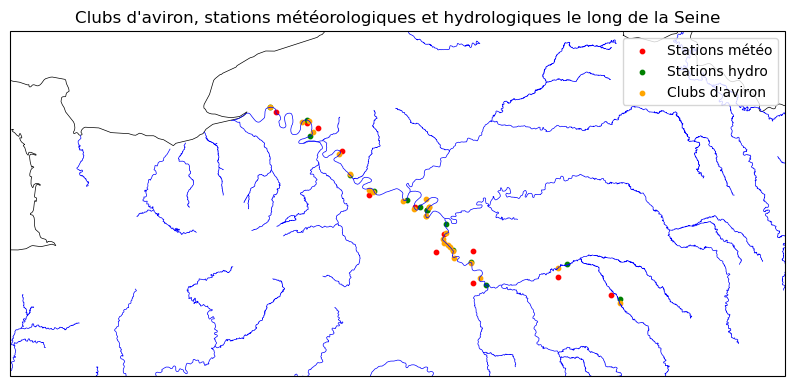

In [50]:
# Tracé du graphique
carte_figures(rivers, coord_ws, coord_hs, clubs_aviron)

On choisit à présent un club d'aviron précis, l'Emulation nautique de Vernon, afin d'analyser les données que l'on a sur son bassin de pratique. Nous cherchons à tracer différents graphiques  (les précipitations, la température ou encore le débit en fonction du temps) pour tenter de remarquer des tendances ou des corrélations entres les variables. 

In [51]:
nom_club = 'Emulation Nautique de Vernon'
nws = clubs_hydro_meteo.loc[clubs_hydro_meteo['Club'] == nom_club, 'NWS'].iloc[0]
nhs = clubs_hydro_meteo.loc[clubs_hydro_meteo['Club'] == nom_club, 'NHS'].iloc[0]
nws_nhs = f'La station météo la plus proche du club {nom_club} est {nws} et la station hydrométrique la plus proche est {nhs}'
display(Markdown(nws_nhs))

La station météo la plus proche du club Emulation Nautique de Vernon est LES ANDELYS et la station hydrométrique la plus proche est La Seine à Vernon - Station débitmétrique (>2006)

---

**2. Graphe des précipitations en fonction du temps**

2. a. <u>Heure par heure</u>

In [52]:
#Création d'une copie du dataframe avec uniquement les précipitations et la température proches du club considéré
meteo_nws = meteo_horaire[meteo_horaire["NOM_USUEL"] == nws].copy()
meteo_nws = meteo_nws.dropna(subset=['RR1', 'T'])

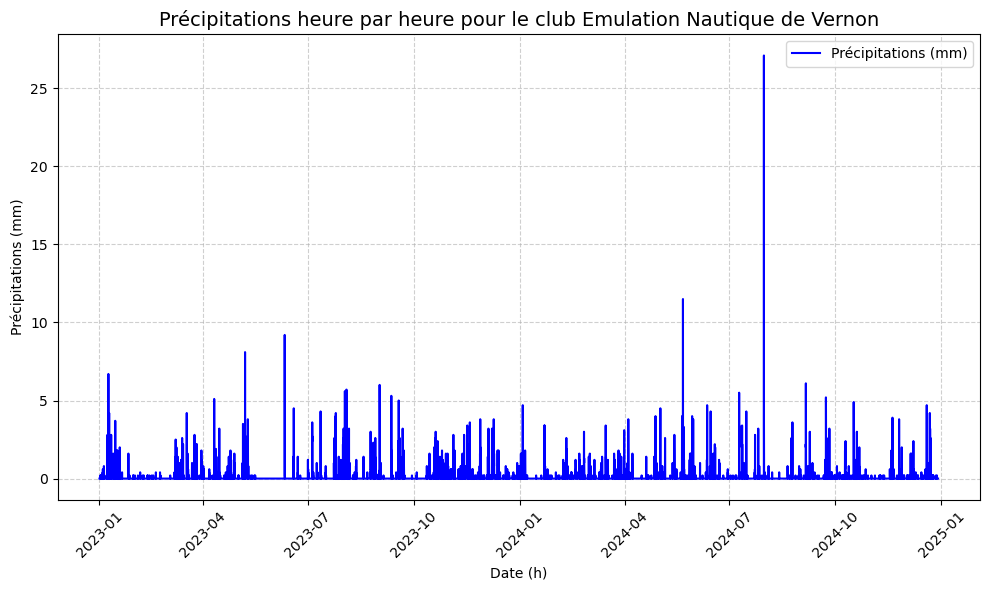

In [53]:
trace_graphique(
    x=meteo_nws["AAAAMMJJHH"],
    y=meteo_nws["RR1"],
    titre=f"Précipitations heure par heure pour le club {nom_club}",
    xlabel="Date (h)",
    ylabel="Précipitations (mm)",
)

Ce graphique détaille les précipitations enregistrées **heure par heure**. Il met en évidence la nature très variable des précipitations, avec de nombreux pics irréguliers.  
- Les pics isolés témoignent de périodes courtes mais **intenses de précipitation**.  
- Entre ces pics, les précipitations sont souvent nulles ou très faibles.  

Cette granularité **horaire**, utile pour analyser la variabilité des précipitations à court terme, rend difficile la lecture des **tendances globales** à cause de l'apparente saturation de l'information.

Pour un modèle de prévision du débit, ces données brutes heure par heure peuvent donc être **trop détaillées** pour être directement exploitées. En effet, les débits d'un cours d'eau dépendent davantage de cumuls de précipitations sur des périodes plus longues (journées ou semaines) que d'événements ponctuels. Typiquement, de grosses averses (juillet-août 2024) sont plus plus susceptibles d'impacter le débit de la Seine que des pluies isolées, c'est ce qu'il serait intéressant d'étudier.

2. b. <u>Par semaine</u>

In [54]:
# On crée un nouveau dataframe où les précipitations sont sommées par semaine
meteo_nws['hebdo'] = meteo_nws['AAAAMMJJHH'].dt.to_period('W')
precipit_hebdo = meteo_nws.groupby('hebdo', as_index=False)['RR1'].sum()
precipit_hebdo['hebdo'] = precipit_hebdo['hebdo'].dt.to_timestamp(how='start')

# Puis on fait une moyenne glissante sur 3 semaines pour lisser la courbe
precipit_hebdo['moy_gliss'] = precipit_hebdo['RR1'].rolling(window=3, min_periods=1, center=True).mean()

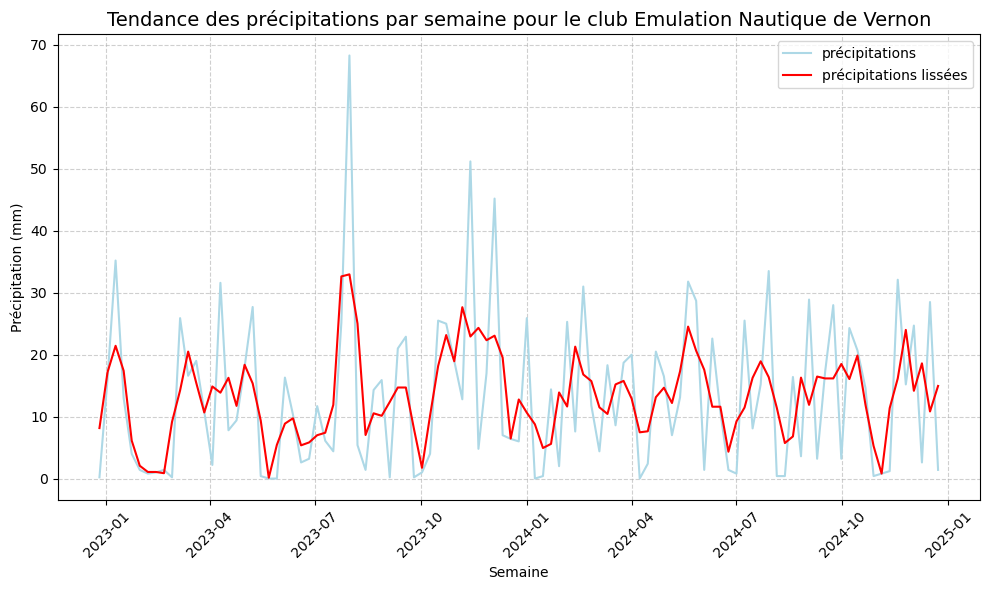

In [55]:
# Préparation des données pour la fonction
y_dico1 = {
    "précipitations": {"y": precipit_hebdo["RR1"], "color": "lightblue", "linestyle": "-"},
    "précipitations lissées": {"y": precipit_hebdo["moy_gliss"], "color": "red", "linestyle": "-"}
}

# Appel de la fonction
trace_graphique_multiple(
    x=precipit_hebdo["hebdo"],
    y_mult=y_dico1,
    titre=f'Tendance des précipitations par semaine pour le club {nom_club}',
    xlabel="Semaine",
    ylabel="Précipitation (mm)",
)

Ce graphique agrège les précipitations à une échelle **hebdomadaire**, ce qui permet de mieux identifier les **tendances globales** dans les précipitations :  
- En bleu clair : la somme hebdomadaire des précipitations montre les fluctuations globales des précipitations au fil du temps.  
- En rouge : la moyenne glissante sur 3 semaines lisse les variations hebdomadaires, révélant les tendances de fond sans être perturbée par des oscillations trop rapides.

Ce lissage est particulièrement utile pour **détecter les périodes humides ou sèches prolongées**, qui influencent directement le débit des cours d'eau. On observe plusieurs pics significatifs sur l'année 2023 (notamment au printemps et en automne), ce qui est cohérent avec les périodes de précipitations accrues.  

Les **sommations hebdomadaires** permettent de mieux **relier les précipitations aux variations de débit**, car elles intègrent une échelle temporelle plus pertinente pour l'évolution du niveau d'eau. La **moyenne glissante** aide à anticiper les périodes où les cours d'eau risquent d'atteindre des niveaux élevés, en réponse à des cumuls prolongés.

---

Pour **prédire le débit d'un cours d'eau**, il serait pertinent d'utiliser les données hebdomadaires comme **variable explicative principale**, en intégrant les tendances de fond issues de la moyenne glissante pour améliorer les prédictions.

---

**3. Graphe des températures en fonction du temps**

3. a. <u>Heure par heure</u>

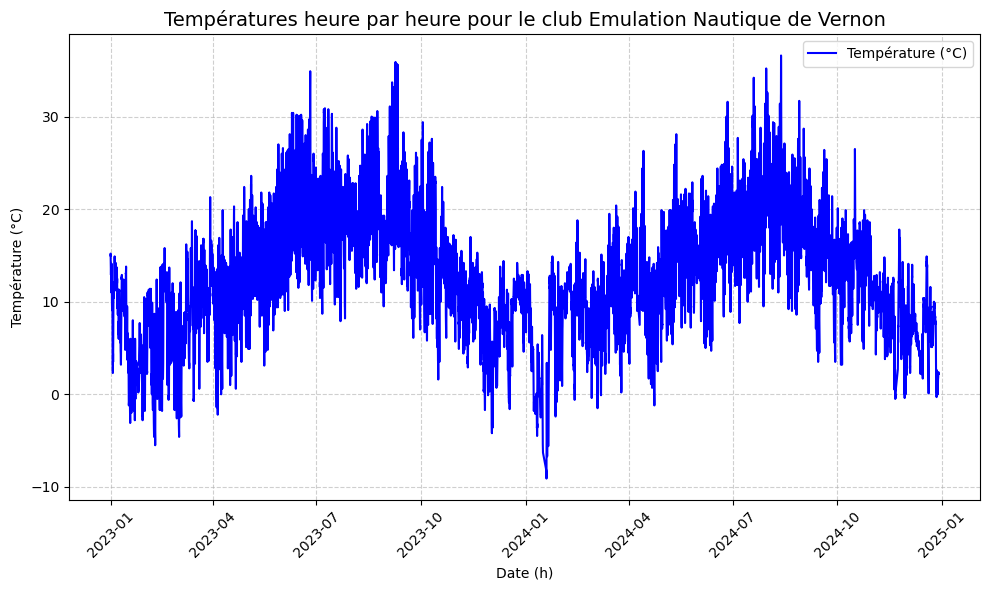

In [56]:
trace_graphique(
    x=meteo_nws["AAAAMMJJHH"],
    y=meteo_nws["T"],
    titre=f"Températures heure par heure pour le club {nom_club}",
    xlabel="Date (h)",
    ylabel="Température (°C)",
)

Ce graphique montre l'évolution de la température en fonction du temps à une résolution horaire. Il met à la fois en évidence les tendances globales de température en fonction des saisons (20-25°C vers juillet-août aussi bien en 2023 qu'en 2024, autour de 5°C en janvier-février) et la variabilité journalière des températures. Plusieurs phénomènes sont à analyser ici : d'abord la **saisonnalité temporelle** : les températures influencent l'évaporation et la fonte des neiges, ce qui peut expliquer un impact potentiel sur le débit des cours d'eau. Ensuite, la **variabilité horaire** est assez importante : cette variabilité peut être liée à des événements météorologiques locaux (comme des fronts froids ou chauds) qui affectent aussi les précipitations et, par extension, les débits des rivières.

En conclusion : les températures, combinées aux précipitations, doivent logiquement influencer directement le débit par la fonte des neiges, l'infiltration dans les sols, et l'évaporation. Ces variations saisonnières et horaires de température doivent donc être intégrées comme une variable explicative dans le modèle de prédiction.

3. b. <u>Par semaine</u>

In [57]:
# On reproduit la même méthode que pour les précipitations
temp_hebdo = meteo_nws.groupby('hebdo', as_index=False)['T'].mean()
temp_hebdo['hebdo'] = temp_hebdo['hebdo'].dt.to_timestamp(how='start')
temp_hebdo['moy_gliss'] = temp_hebdo['T'].rolling(window=3, min_periods=1, center=True).mean()

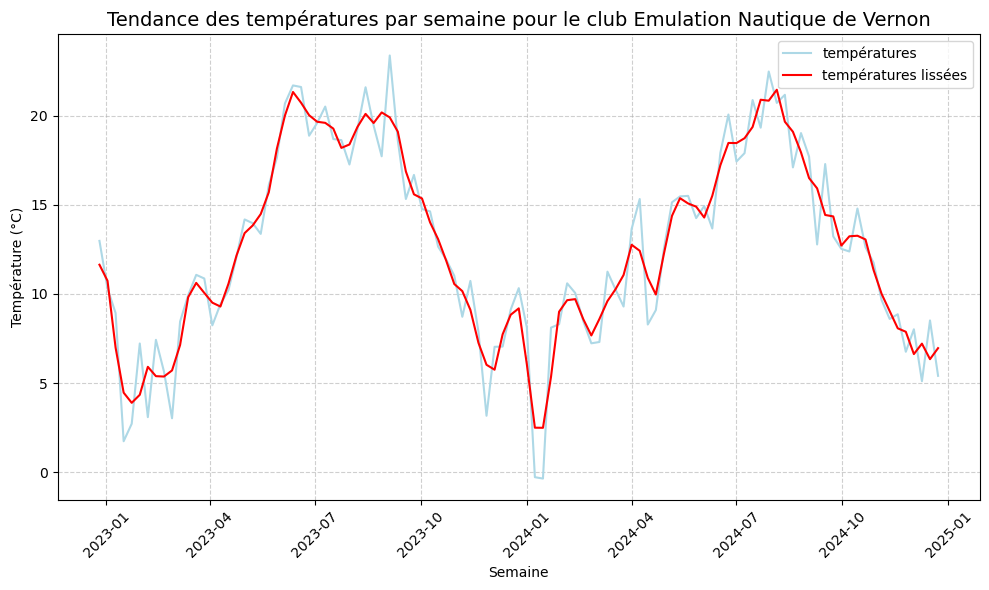

In [58]:
# Préparation des données pour la fonction
y_dico2 = {
    "températures": {"y": temp_hebdo["T"], "color": "lightblue", "linestyle": "-"},
    "températures lissées": {"y": temp_hebdo["moy_gliss"], "color": "red", "linestyle": "-"}
}

# Appel de la fonction
trace_graphique_multiple(
    x=temp_hebdo["hebdo"],
    y_mult=y_dico2,
    titre=f'Tendance des températures par semaine pour le club {nom_club}',
    xlabel="Semaine",
    ylabel="Température (°C)",
)

Ici, on se restreint à la compréhension des tendances globales de températures. Cette restriction ne permet pas de voir de corrélation directe avec les précipitations. Les températures et les précipitations jouent donc probablement leur rôle dans la prédiction du débit des cours d'eau de manière indépendante.

Mais on peut d'ores-et-déjà émettre quelques hypothèses : 
- plus les précipitations sont importantes et plus elles durent longtemps, plus le débit sera élevé, ceteris paribus
- plus la température est élevée et plus la période de chaleur est longue, plus le débit sera faible, ceteris paribus
- plus la température est élevée, plus les précipitations ont un impact positif sur le débit (par ruissellement)

**4. Graphe du débit en fonction du temps**

In [59]:
#Création d'une copie du dataframe avec uniquement les précipitations et la température proches du club considéré
debit_nhs = debit_horaire[debit_horaire["NOM_USUEL_H"] == nhs].copy()
debit_nhs = debit_nhs.dropna(subset='debit')

KeyError: 'NOM_USUEL_H'

In [ ]:
trace_graphique(
    x=debit_nhs["AAAAMMJJHH"],
    y=debit_nhs["debit"],
    titre=f"Débit heure par heure pour le club {nom_club}",
    xlabel="Date (h)",
    ylabel="Debit (en m³/s)",
)

In [ ]:
# On reproduit la même méthode que pour les précipitations
debit_nhs['hebdo'] = debit_nhs['AAAAMMJJHH'].dt.to_period('W')
debit_hebdo = debit_nhs.groupby('hebdo', as_index=False)['debit'].mean()
debit_hebdo['hebdo'] = debit_hebdo['hebdo'].dt.to_timestamp(how='start')
debit_hebdo['moy_gliss'] = debit_hebdo['debit'].rolling(window=3, min_periods=1, center=True).mean()

In [ ]:
# Préparation des données pour la fonction
y_dico2 = {
    "débit": {"y": debit_hebdo["debit"], "color": "lightblue", "linestyle": "-"},
    "débit lissé": {"y": debit_hebdo["moy_gliss"], "color": "red", "linestyle": "-"}
}

In [ ]:
# Appel de la fonction
trace_graphique_multiple(
    x=debit_hebdo["hebdo"],
    y_mult=y_dico2,
    titre=f'Tendance du débit par semaine pour le club {nom_club}',
    xlabel="Semaine",
    ylabel="Débit (en m³/s)",
)

In [ ]:
from utils.data_modeling import (
    correlation1,
    correlation2,
    plot_correlations,
    create_features,
)

# **Data modeling**

Formalisation des requêtes de recherche dans les dictionnaires précédemment crées : 
Il suffit d'entrer le nom du club sur lequel on souhaite obtenir l'ensemble des données

In [ ]:
nom_club = 'Emulation Nautique de Vernon'

def get_station_data_by_club(club_name, df_adresses_clubs, dictionnaire_df_stations_hydro):
    """
    Récupère les données de débit de la station hydrométrique associée à un club d'aviron.

    Args:
        club_name (str): Le nom du club d'aviron.
        df_adresses_clubs (DataFrame): DataFrame contenant les clubs et leurs stations associées.
        dictionnaire_df_stations_hydro (dict): Dictionnaire contenant les DataFrames des données de débit.

    Returns:
        DataFrame or None: Les données de débit de la station associée au club ou None si non trouvé.
    """
 # Trouver l'identifiant de la station associée au club
    station_id = df_adresses_clubs.loc[df_adresses_clubs['Club'] == club_name, 'NUM_POSTE'].values
    if len(station_id) == 0:
        print(f"Aucune station associée au club : {club_name}")
        return None

    station_id = station_id[0]  # Extraire l'identifiant unique
    
    # Récupérer les données de la station
    if station_id in dictionnaire_df_stations_hydro:
        return dictionnaire_df_stations_hydro[station_id]
    else:
        print(f"Aucune donnée de débit trouvée pour la station : {station_id}")
        return None


print(get_station_data_by_club ( nom_club, stations_hydro_clubs, dictionnaire_df_stations_hydro))
df_debit=get_station_data_by_club ( nom_club, stations_hydro_clubs, dictionnaire_df_stations_hydro)


def get_meteo_data_by_club(club_name, df_adresses_clubs, dictionnaire_df_stations_meteo ):

 # Trouver l'identifiant de la station associée au club
    station_id = df_adresses_clubs.loc[df_adresses_clubs['Club'] == club_name, 'NUM_POSTE'].values
    if len(station_id) == 0:
        print(f"Aucune station associée au club : {club_name}")
        return None

    station_id = station_id[0]  # Extraire l'identifiant unique
    
    # Récupérer les données de la station
    if station_id in dictionnaire_df_stations_meteo:
        return dictionnaire_df_stations_meteo[station_id]
    else:
        print(f"Aucune donnée de débit trouvée pour la station : {station_id}")
        return None

print(get_meteo_data_by_club ( nom_club , stations_meteo_clubs, dictionnaire_df_stations_meteo))

df_meteo=get_meteo_data_by_club( nom_club, stations_meteo_clubs, dictionnaire_df_stations_meteo)



                 Datetime  Valeur (en m³/s)
0     2023-01-01 00:00:00               503
1     2023-01-01 01:00:00               508
2     2023-01-01 02:00:00               515
3     2023-01-01 03:00:00               521
4     2023-01-01 04:00:00               522
...                   ...               ...
16795 2024-11-30 19:00:00               713
16796 2024-11-30 20:00:00               708
16797 2024-11-30 21:00:00               696
16798 2024-11-30 22:00:00               693
16799 2024-11-30 23:00:00               686

[16800 rows x 2 columns]
                        T  RR1
Datetime                      
2023-01-01 00:00:00  15.0  0.0
2023-01-01 01:00:00  15.2  0.0
2023-01-01 02:00:00  14.9  0.0
2023-01-01 03:00:00  14.4  0.0
2023-01-01 04:00:00  14.1  0.0
...                   ...  ...
2024-12-20 23:00:00   7.7  0.4
2024-12-21 00:00:00   7.8  0.4
2024-12-21 01:00:00   8.1  0.0
2024-12-21 02:00:00   8.4  0.0
2024-12-21 03:00:00   8.2  0.0

[34568 rows x 2 columns]


Et la fusion : 

In [ ]:
# Fusionner les DataFrames sur la colonne datetime
df_combined = pd.merge(df_debit, df_meteo, on='Datetime', how='outer', suffixes=('_debit', '_meteo'))

# Trier les données par datetime et réinitialiser l'index
df_combined = df_combined.sort_values(by='Datetime').reset_index(drop=True)

df_combined
df_combined = df_combined.drop_duplicates(subset='Datetime').reset_index(drop=True)
# Afficher les premières lignes du DataFrame combiné
print(df_combined)

                 Datetime  Valeur (en m³/s)     T  RR1
0     2023-01-01 00:00:00             503.0  15.0  0.0
1     2023-01-01 01:00:00             508.0  15.2  0.0
2     2023-01-01 02:00:00             515.0  14.9  0.0
3     2023-01-01 03:00:00             521.0  14.4  0.0
4     2023-01-01 04:00:00             522.0  14.1  0.0
...                   ...               ...   ...  ...
17279 2024-12-20 23:00:00               NaN   7.7  0.4
17280 2024-12-21 00:00:00               NaN   7.8  0.4
17281 2024-12-21 01:00:00               NaN   8.1  0.0
17282 2024-12-21 02:00:00               NaN   8.4  0.0
17283 2024-12-21 03:00:00               NaN   8.2  0.0

[17284 rows x 4 columns]


Il faudra restreindre les datasets de meteo au 30 novembre 2024 (la ou je me suis arreté dans le téléchargement des df débit)

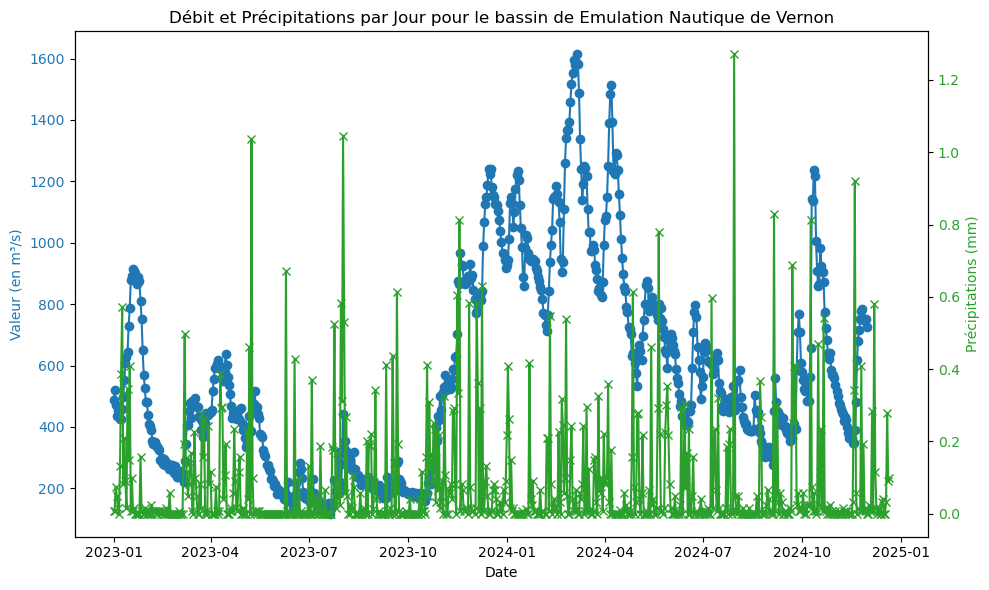

In [ ]:
# Lissage par jour (moyenne quotidienne)
df_daily = df_combined.groupby(df_combined['Datetime'].dt.date).agg({'Valeur (en m³/s)': 'mean', 'RR1': 'mean'}).reset_index()

# Créer le plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot des débits sur le premier axe
ax1.plot(df_daily['Datetime'], df_daily['Valeur (en m³/s)'], color='tab:blue', label='Débit', linestyle='-', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Débit (en m³/s)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Ajouter un deuxième axe pour les précipitations
ax2 = ax1.twinx()
ax2.plot(df_daily['Datetime'], df_daily['RR1'], color='tab:green', label='Précipitations', linestyle='-', marker='x')
ax2.set_ylabel('Précipitations (mm)', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')


# Titre et affichage
plt.title(f'Débit et Précipitations par Jour pour le bassin de {nom_club}')
fig.tight_layout()
plt.show()

In [ ]:
# 3. Data modeling

In [ ]:
from utils.data_modeling import (
    correlation1,
    correlation2,
    plot_correlations,
    create_features,
)

**1. Constitution du dataframe final**
On crée dorénavant un gros dataframe avec toutes les données qui serviront pour l'entraînement du modèle :
- le club d'aviron
- ses coordonnées GPS
- les station météo et hydro les plus proches
- l'heure de prélèvement des données
- le débit, les précipitations et la température à cette heure

In [ ]:
#1: on joint les données de debit_horaire avec clubs_hydro_meteo sur NUM_NHS
debit_club = debit_horaire.merge(
    clubs_hydro_meteo[['Club', 'LAT', 'LON', 'NUM_NHS', 'NHS']],
    left_on='NUM_POSTE_H',
    right_on='NUM_NHS',
    how='inner'

SyntaxError: incomplete input (3374014626.py, line 6)

In [ ]:
# 2: on joint les données de meteo_horaire avec clubs_hydro_meteo sur NUM_NWS
meteo_club = meteo_horaire_train.merge(
    clubs_hydro_meteo[['Club', 'LAT', 'LON', 'NUM_NWS', 'NWS']],
    left_on='NUM_POSTE',
    right_on='NUM_NWS',
    how='inner'
)

In [ ]:
# 3: on combine les deux DataFrames sur le Club et la colonne temporelle 'AAAAMJJHH'
combined = debit_club.merge(
    meteo_club,
    on=['Club', 'AAAAMMJJHH'],
    suffixes=('_hydro', '_meteo')
)

In [ ]:
# 4: on sélectionne les colonnes pertinentes et on copie le dataframe pour éviter les intéractions fâcheuses
result = combined[['Club', 'LAT', 'LON', 'NHS', 'NWS', 'AAAAMMJJHH', 'debit', 'RR1', 'T']].copy()


Au préalable, on doit s'assurer que toutes les valeurs du dataframe sont numériques y compris les dates.


In [ ]:
# On convertit les valeurs en nombre
result["debit"] = pd.to_numeric(result["debit"], errors="coerce")
result["LAT"] = pd.to_numeric(result["LAT"], errors="coerce")
result["LON"] = pd.to_numeric(result["LON"], errors="coerce")
result = result.dropna(subset=["debit", "RR1", "T"])

# On supprime les colonnes inutiles pour la prédiction
result = result.drop(columns=["NWS", "NHS"])

# On extrait les caractéristiques temporelles 
result["year"] = result["AAAAMMJJHH"].dt.year
result["month"] = result["AAAAMMJJHH"].dt.month
result["day"] = result["AAAAMMJJHH"].dt.day
result["hour"] = result["AAAAMMJJHH"].dt.hour

# Supprimer la colonne datetime originale si elle n'est plus utile
result = result.drop(columns=["AAAAMMJJHH"])


2. Etude approfondie de corrélation entere les variables


In [ ]:
# Corrélation entre le débit et les précipitations aux heures précédentes
correlation1(result, "RR1", 1, 26, 6)


In [ ]:
# Corrélation entre le débit et la température aux heures précédentes
correlation1(result, "T", 1, 26, 6)

In [ ]:
# Corrélation entre le débit et le débit aux heures précédentes
correlation1(result, "debit", 1, 26, 6)


Il vient sans surprise que le débit à l'heure h est très corrélé (coefficient quasiment égal à 1) au débit aux heures h-1, h-2, etc. Inversement, celui-ci semble plutôt indépendant (coefficient faible voire presque nul) des précipitations ou des changements de température récents. Mais disposer du débit de l'heure précédente n'est pas forcément très réaliste dans une optique de prédicition du débit d'un jour sur l'autre par exemple. On peut donc se concentrer sur l'étude de corrélation entre le débit et la moyenne des températures sur les derniers jours, ou entre le débit et la somme des précipitations sur les derniers jours.

In [ ]:
# Corrélation entre le débit et les précipitations sur une période donnée
windows = list(range(24, 6*24+1, 24)) + list(range(7*24, 4*7*24+1, 7*24)) # on définit la fenêtre
correlations_RR1 = correlation2(result, column="RR1", target="debit", periods=windows)
plot_correlations(correlations_RR1, title="Corrélation entre RR1_sum et débit en fonction de la fenêtre")

In [ ]:
# Corrélation entre le débit et la température sur une période donnée
correlations_T = correlation2(result, column="T", target="debit", periods=windows)
plot_correlations(correlations_T, title="Corrélation entre T_mean et débit en fonction de la fenêtre")

In [ ]:
# Corrélation entre le débit et la température sur une période donnée
correlations_debit = correlation2(result, column="debit", target="debit", periods=windows)
plot_correlations(correlations_debit, title="Corrélation entre debit_mean et débit en fonction de la fenêtre")

Sous contrainte de données pour faire des prédictions effectives (30 jours) et par souci de réalisme, nous choisissons pour l'entraînement de retenir les données de débit du jour précédent, la moyenne des températures sur les 28 derniers jours et la somme des précipitations sur les 28 derniers jours également.

## 3.Modélisation finale

In [ ]:
# Créer les caractéristiques
result = create_features(result).copy()

# Supprimer les lignes avec des valeurs manquantes dues aux décalages
result = result.dropna()

# Définir les caractéristiques et la cible
features = [col for col in result.columns if col not in ["datetime", "Club", "debit"]]
X = result[features]
y = result["debit"]

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner un modèle XGBoost
model = XGBRegressor(
    n_estimators=100,  # Nombre d'arbres
    learning_rate=0.1,  # Taux d'apprentissage
    max_depth=5,  # Profondeur maximale des arbres
    subsample=0.8,  # Fraction d'échantillons pour chaque arbre
    colsample_bytree=0.8, # Fraction de colonnes utilisées par arbre
    random_state=42
)

model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluer le modèle
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Affichage des résultats
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
